# Data and Setup
For this project, our primary dataset will be a dataframe that contains **51 US Capital Cities** with a list of variables that characterize certain features for each city. These variables/features include:

* City's Name
* City's State
* City's County
* Latitude Coordinate
* Longitude Coordinate
* Population
* Density
* Timezone
* Ranking (1-3, descending in importance with unknown/unstated criteria; more on this later)
* Number of Zip Codes in City
* % change average RGB values per year (see below)
    
Outside of this dataset, we collected satellite images of each U.S. capital from NASA's Earth API to observe changes over time. NASA pre-processes these images so effects like the time of day are minimized. The API is tricky to work with however, since it provides only so many images throughout a year, and only so many of those images contain traces of land, given that clouds tend to fill most of them.


In [13]:
import os, requests, base64, imageio
from PIL import Image
from io import BytesIO

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
import statsmodels.formula.api as sm     # used statsmodels.formula.api.ols() for OLS
from sklearn import linear_model         # used sklearn.linear_model.LinearRegression() for OLS
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import homogeneity_score, v_measure_score
from sklearn.preprocessing import scale


import seaborn as sn
import pandas as pd
import scipy as sc
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

us_capitals = pd.read_csv("just_capitals.csv")
us_capitals = us_capitals.drop(columns='Unnamed: 0')

# Exploratory Analysis

In [8]:
print('Description of U.S. Capitals Dataset:')
us_capitals.describe()

Description of U.S. Capitals Dataset:


,lat,long,population,density,ranking,zips,dR/year,dG/year,dB/year
count,51.000000,51.000000,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,39.409669,-93.135641,8.861300e+05,1294.019608,1.745098,33.117647,0.007183,0.006346,0.004890
std,5.674883,18.612157,1.336798e+06,1144.495548,0.483452,42.916965,0.010532,0.008589,0.005382
min,21.329400,-157.846000,7.372000e+03,4.000000,1.000000,1.000000,0.000069,0.000117,0.000041
25%,36.002000,-102.779700,1.142755e+05,596.000000,1.000000,8.500000,0.001825,0.001829,0.001542
50%,39.771000,-89.653800,3.253500e+05,938.000000,2.000000,24.000000,0.004563,0.004056,0.003010
75%,42.690300,-78.059550,1.057268e+06,1533.000000,2.000000,39.500000,0.006542,0.006053,0.006120
max,58.454600,-69.731900,5.449398e+06,5532.000000,3.000000,292.000000,0.059436,0.046600,0.025569


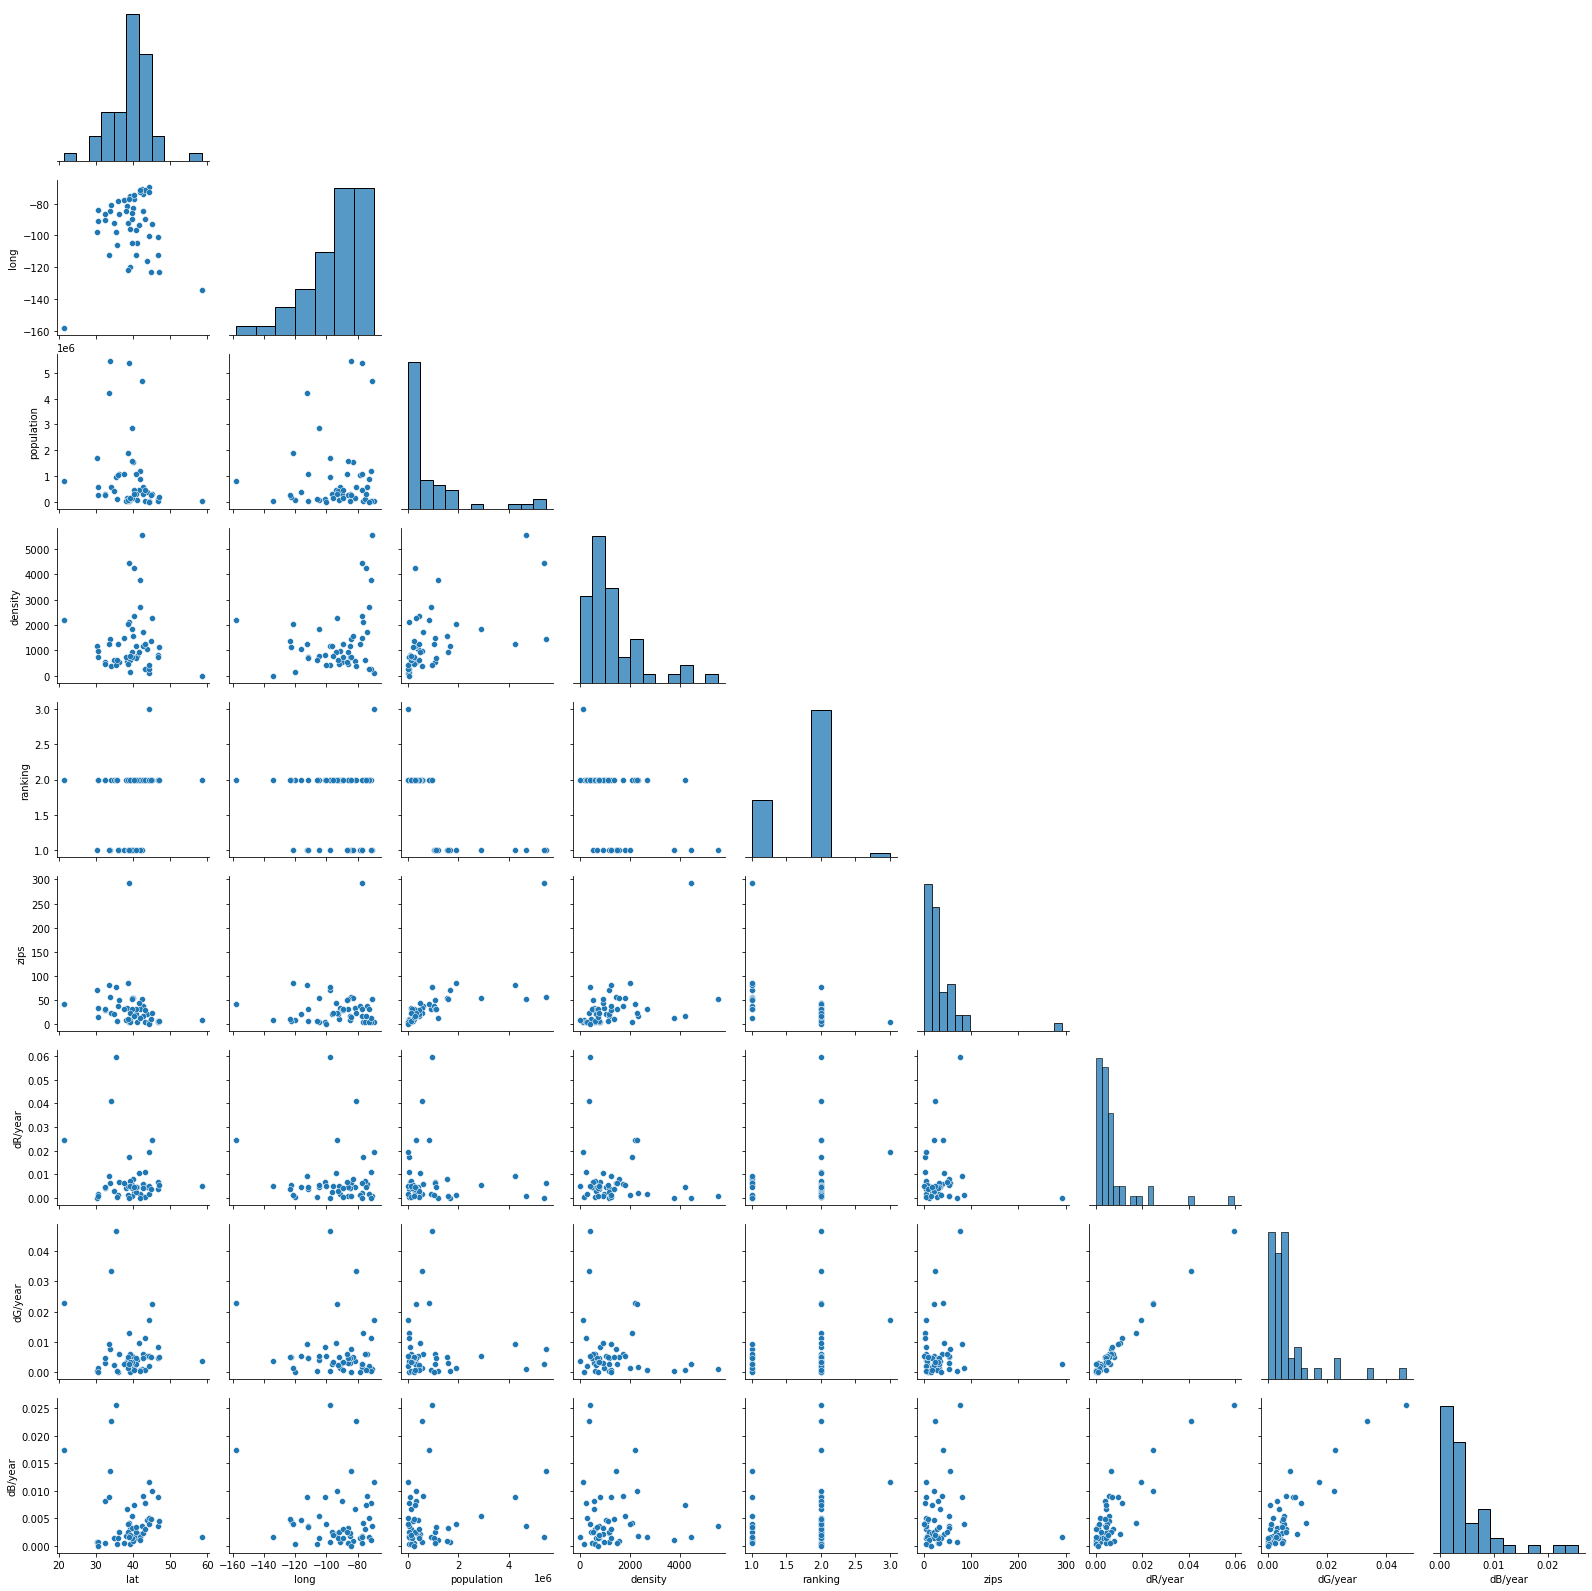

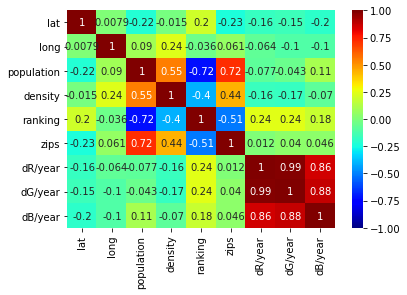

In [9]:
from IPython.display import display
import ppscore as pps

sn.pairplot(us_capitals, corner=True)

# Calculate Correlation Matrix

capital_correlation = us_capitals.corr()
plt.figure()
sn.heatmap(capital_correlation, vmin=-1, vmax=1, cmap='jet', annot=True)
plt.show()

**INTERPRETATION:**
Visably the 'ranking' variable appears to be most correlated to a city's density, population, and number of zip codes. However, since our project included image analysis we wanted to include the data that was pulled from the queryed images. Initially we wondered if the percent change in RGB/year would be an accurate predictor of population, and or density of population in capital cities. However, from the data visualization above the variable RGB/year values looked to be correlated with population and density in regions. For instance it looks like various RGB/year changes are correlated with density from 0-1000, and again from 1000-2000, and finally from 2000+. Similar behavior is seen when looking at RGB/year when compared with population. Therefore, we have decided to create 2 new variables to our data set, both categorical, that explain population and density on a scale of 1-3, similar to how the 'ranking' variable is set up. Later, we will explore PCA Analysis on the entire data set and determine the effectiveness of PCA on predicting the variance in 'Population' and 'Density'. Lastly, we will explore the effect of RGB/year on the 3 categorical variables (population_rank, density_rank, and ranking).

# CREATION OF NEW VARIABLES

**Population Rank:**
1. : 0 - 1 million
2. : 1 - 2.5 million
3. : 2.5+ million

**Density Rank:**
1. : 0 - 1000
2. : 1000 - 2000
3. : 2000+

In [15]:
criteria1 = [us_capitals['density'].between(0, 1000), us_capitals['density'].between(1000, 2000), us_capitals['density'].between(2000, 6000)]
criteria2 = [us_capitals['population'].between(0, 1e6), us_capitals['population'].between(1e6, 2.5e6), us_capitals['population'].between(2.5e6, 7e6)]
categories = [1, 2, 3]

us_capitals['density_rank'] = np.select(criteria1, categories, 0) 
us_capitals['population_rank'] = np.select(criteria2, categories, 0)

# PCA
PCA will be used to decompose the RGB dimensions into principle component(s) to determine quality of clustering, for both categorical population, and density. Before, attempting PCA we dropped Washington DC as it was a major outlier, and often not referred to as a capital of a state.

In [16]:
us_capitals = us_capitals.drop(50)

**PCA for Population**

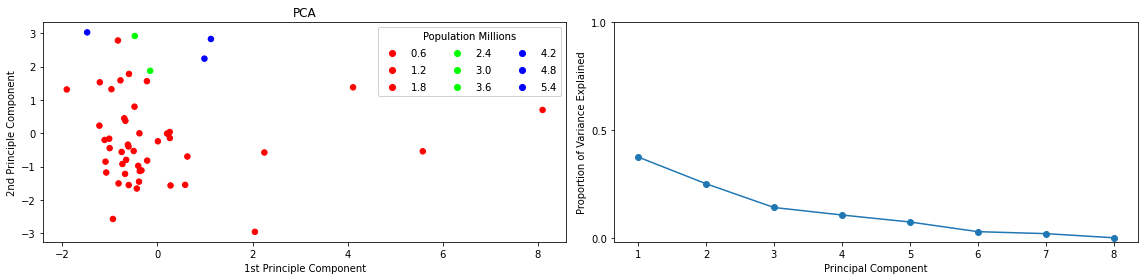

[0.37587119 0.25166546 0.14147814 0.10656402 0.07409485 0.0292817
 0.02006706 0.00097759]


In [17]:
pca_model = PCA()
X = scale(us_capitals.drop(['population', 'state_id', 'city','timezone','county','density_rank','population_rank'],axis=1).values)
X_PCA = pca_model.fit_transform(X)
y = us_capitals['population'].values

cluster_model = AgglomerativeClustering(linkage='ward', n_clusters=6)
y_pred = cluster_model.fit_predict(X)

var_ratio = pca_model.explained_variance_ratio_
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 2, 1)

scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y, cmap=cmap_bold,s=30)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", ncol= 3, title="Population Millions")

ax.add_artist(legend1)

ax.set_xlabel('1st Principle Component')
ax.set_ylabel('2nd Principle Component')
ax.set_title('PCA')

ax = fig.add_subplot(1, 2, 2)

ax.plot([1,2,3,4,5,6,7,8], var_ratio, '-o')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_xlabel('Principal Component')
ax.set_yticks([0,0.5,1])
ax.set_xticks([1,2,3,4,5,6,7,8])

plt.tight_layout()  

plt.show()
print(var_ratio)



From the plot above on the right we see that only 37.6% of the variance in the data is contained in the first principle component. Therefore, we will only use the first Principle component.

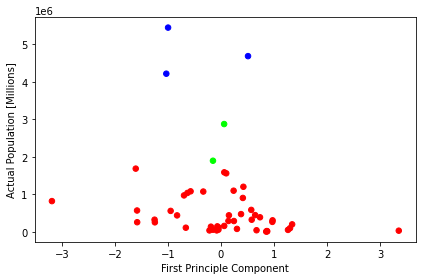

In [18]:
fig = plt.figure(figsize=plt.figaspect(0.35))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:, 0], y, c=y, cmap=cmap_bold,s=30)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Actual Population [Millions]')

plt.tight_layout()  
plt.show()

**PCA for Density**

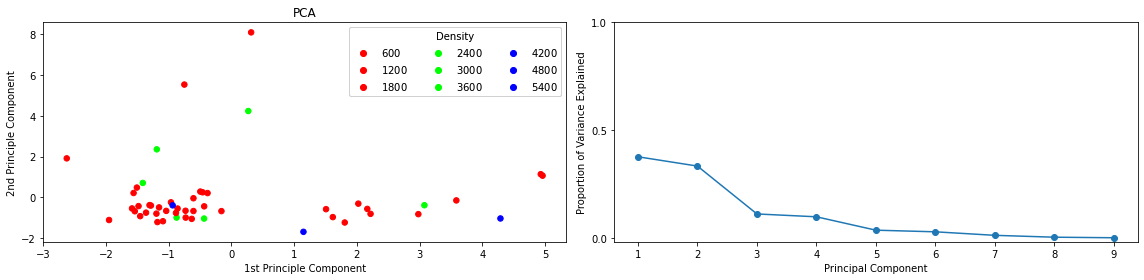

[0.37655604 0.33337317 0.1112576  0.09807626 0.03598049 0.02839417
 0.01207493 0.00342483 0.0008625 ]


In [19]:
X = scale(us_capitals.drop(['state_id', 'city','timezone','county','density','density_rank'],axis=1).values)
X_PCA = pca_model.fit_transform(X)
y = us_capitals['density'].values

cluster_model = AgglomerativeClustering(linkage='ward', n_clusters=6)
y_pred = cluster_model.fit_predict(X)

var_ratio = pca_model.explained_variance_ratio_
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 2, 1)

scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y, cmap=cmap_bold,s=30)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", ncol= 3, title="Density")

ax.add_artist(legend1)

ax.set_xlabel('1st Principle Component')
ax.set_ylabel('2nd Principle Component')
ax.set_title('PCA')

ax = fig.add_subplot(1, 2, 2)

ax.plot([1,2,3,4,5,6,7,8,9], var_ratio, '-o')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_xlabel('Principal Component')
ax.set_yticks([0,0.5,1])
ax.set_xticks([1,2,3,4,5,6,7,8,9])

plt.tight_layout()  

plt.show()
print(var_ratio)


From the plot above on the right we see that 37.6% and 33.3% of the variance in the data is contained in the first two principle components. Therefore, we will only use the first and second principle components.

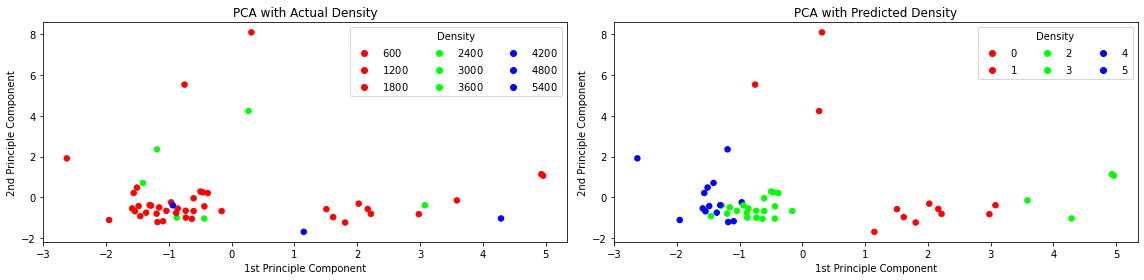

[0.37655604 0.33337317 0.1112576  0.09807626 0.03598049 0.02839417
 0.01207493 0.00342483 0.0008625 ]


In [20]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 2, 1)

scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y, cmap=cmap_bold,s=30)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", ncol= 3, title="Density")
ax.set_xlabel('1st Principle Component')
ax.set_ylabel('2nd Principle Component')
ax.set_title('PCA with Actual Density')

ax = fig.add_subplot(1, 2, 2)

scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred, cmap=cmap_bold,s=30)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", ncol= 3, title="Density")

ax.set_xlabel('1st Principle Component')
ax.set_ylabel('2nd Principle Component')
ax.set_title('PCA with Predicted Density')

plt.tight_layout()  

plt.show()
print(var_ratio)


**Interpretation**
From PCA of both Density and Population the predictions were both poor. This is visually seen in the plot above as the PCA qualifier was only able to classify a handful of data points correctly. We are unclear why PCA render such poor results. If there were more time we would plan to dive back in and see what variables would do the best job at prediction Population and or Density of capital cities. 

# Analysis of New Variables

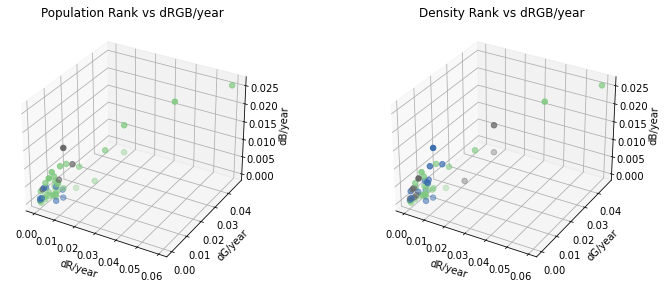

In [21]:
variables_of_interest = ['dR/year', 'dG/year', 'dB/year']

X = us_capitals[variables_of_interest].values
y = us_capitals['population_rank'].values

fig = plt.figure(figsize=plt.figaspect(0.35))

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(X[:, 0], X[:, 1],zs= X[:, 2], c=y, cmap='Accent',s=30)

ax.set_xlabel('dR/year')
ax.set_ylabel('dG/year')
ax.set_zlabel('dB/year')
ax.set_title('Population Rank vs dRGB/year')

ax = fig.add_subplot(1, 2, 2, projection='3d')
y = us_capitals['density_rank'].values

ax.scatter(X[:, 0], X[:, 1],zs= X[:, 2], c=y, cmap='Accent',s=30)

ax.set_xlabel('dR/year')
ax.set_ylabel('dG/year')
ax.set_zlabel('dB/year')
ax.set_title('Density Rank vs dRGB/year')

plt.tight_layout()  
plt.show()


**2D View**

/Users/joe95/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/joe95/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/joe95/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/joe95/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/joe95/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/joe95/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: 

<Figure size 432x288 with 0 Axes>

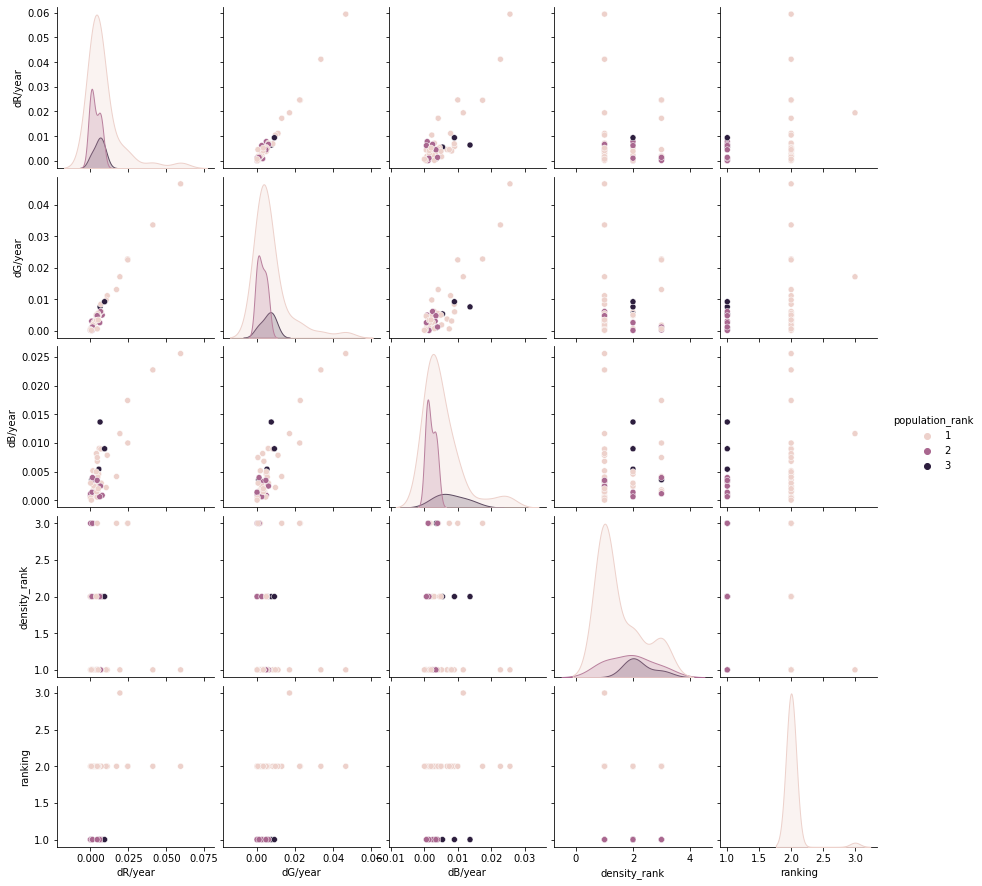

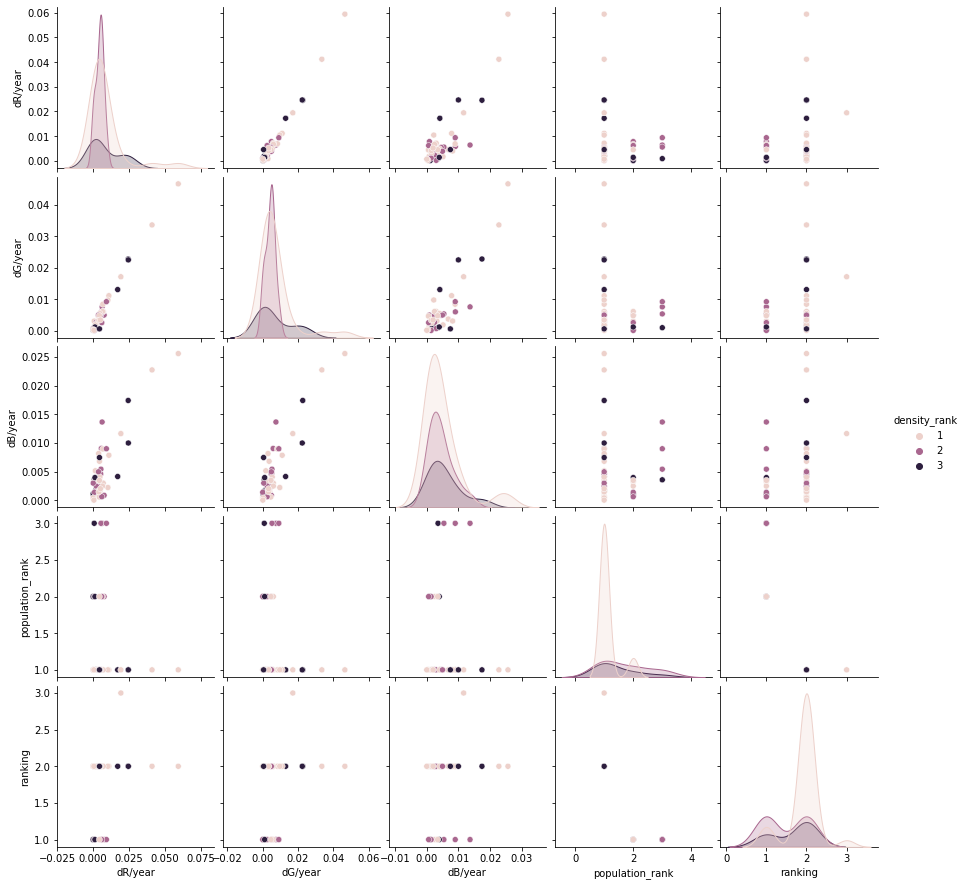

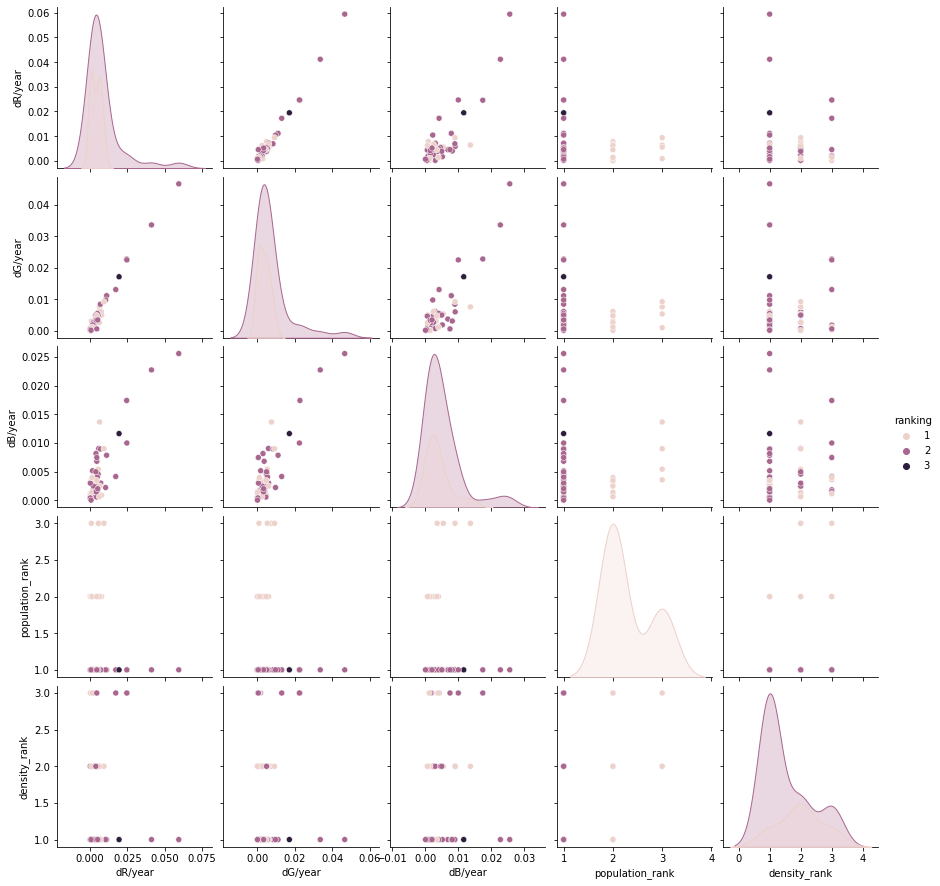

In [23]:
plt.figure()
variables_of_interest = ['dR/year', 'dG/year', 'dB/year','population_rank','density_rank', 'ranking']

sn.pairplot(us_capitals[variables_of_interest], hue='population_rank')
sn.pairplot(us_capitals[variables_of_interest], hue='density_rank')
sn.pairplot(us_capitals[variables_of_interest], hue='ranking')
plt.show()

# Linear Regression